In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import tqdm
from tqdm.notebook import tqdm

### **Loading MNIST**

In [ ]:
train_data = torchvision.datasets.MNIST('dataset', train=True, download=True, transform=torchvision.transforms.ToTensor())

# print(f'There are {len(train_data)} images in the training set!')

100%|██████████| 9912422/9912422 [00:00<00:00, 104687795.85it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 75568118.42it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28343933.36it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14586928.61it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

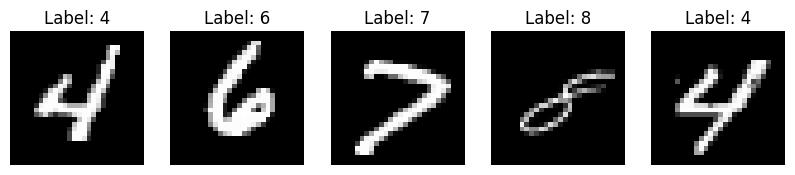

In [ ]:
images, labels = next(iter(train_loader)) # load from the dataloader


plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  random_index = np.random.randint(0, len(images) - 1)  # Choose a random index
  plt.axis('off')
  plt.title(f'Label: {labels[random_index].item()}')
  plt.imshow(images[random_index].squeeze().numpy(), cmap = 'gray')

Generating Noisy Image at Different Steps

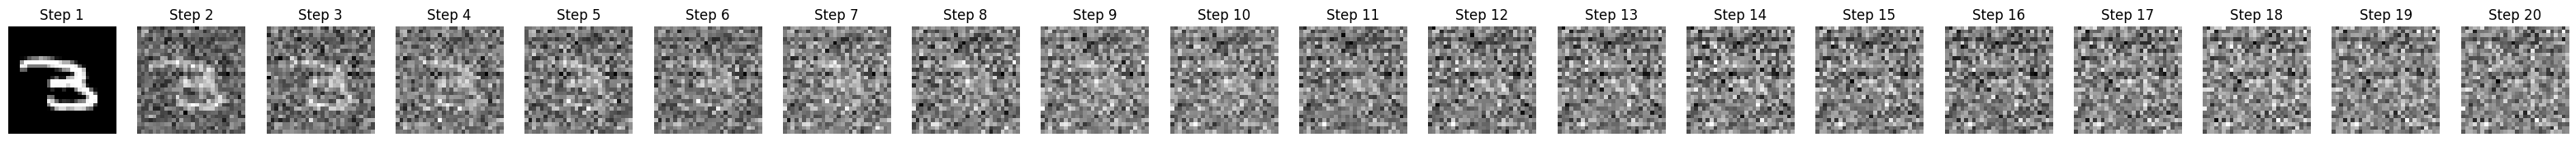

In [ ]:
images, labels = next(iter(train_loader))
random_index = np.random.randint(0, len(images) - 1)  # Choose a random index
noisy_images = images.clone()

sigma = .35  # standard deviation
noise_steps = 20  # number of steps we apply noise

plt.figure(figsize=(noise_steps * 2, 10))
for i in range(noise_steps):
    # Draw noise from a normal distribution with standard deviation sigma.
    noise = torch.normal(0, sigma, images[random_index].shape)
    plt.subplot(1, noise_steps, i + 1)
    plt.imshow(noisy_images[random_index].squeeze(), cmap='gray')
    plt.title(f"Step {i + 1}")  # Adding the step number as the title
    plt.axis('off')
    # Add the noise to the image.
    noisy_images[random_index] = noise + noisy_images[random_index]

plt.show()

### **Architecture**

In [ ]:
def normalize(x, sigma):
  # x is (batch_size, 28*28)
  mean = x.mean(dim=-1).view(-1, 1)
  # mean is (batch_size, 1) i.e. a different mean for each image
  std = x.std(dim=-1).view(-1,1)
  # std is (batch_size, 1) i.e. a different standard deviation for each image
  return (x-mean) / std * sigma

A small Architecture Chosen instead of U-Net due to limited compute.

In [ ]:
class Diffuser(nn.Module):

  def __init__(self, sigma, noise_steps):
    super(Diffuser, self).__init__()

    # Neural network layers
    self.layers = nn.Sequential(
      nn.Linear(28*28+noise_steps+10, 28*28),
      nn.ReLU(),
      nn.Linear(28*28, 28*28)
    )

    # Parameters
    self.sigma = sigma
    self.noise_steps = noise_steps

  def forward(self, images, noise_level, labels):

    # Flatten the image
    images = images.view(-1, 28*28)

    # One-hot encode noise level and labels
    noise_level_encoding = F.one_hot(
        torch.tensor([noise_level]*images.shape[0]), num_classes=self.noise_steps
    ).to(device)

    labels_encoding = F.one_hot(labels, num_classes=10).to(device)

    # Concatenate inputs
    x = torch.cat((images, noise_level_encoding, labels_encoding), 1)
    # Pass through neural network layers
    x = self.layers(x)
    # Normalize
    x = normalize(x, self.sigma)
    # Reshape output
    x = x.view(-1, 1, 28, 28)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Diffuser(sigma, noise_steps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1)
criterion = nn.MSELoss()

In [ ]:
standard_normal = torch.distributions.Normal(0, sigma)
standard_normal.loc = standard_normal.loc.to(device)
standard_normal.scale = standard_normal.scale.to(device)

The initial noise will be sampled from a mean-centered normal distribution with standard deviation `sigma` `noise_steps`^1/2.

### Training

To train the model, we'll iterate through each batch in every epoch. During this process, we'll experiment with different noise levels in a random sequence. This randomness helps in diversifying the gradient descent updates. Employing the variance trick for normal distributions, we can obtain a noisy image after a certain number of steps of noise application. This is achieved by sampling from a distribution with a standard deviation equal to the square root of the noise level multiplied by the base noise level, representing the variance.





Number of Epochs chosen as 100 due GPU Limits of Basic Colab Account

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, labels in tqdm(train_loader):
        # Put the images on the device.
        images = images.to(device)

        for noise_level in torch.randperm(noise_steps):

            # Build the less noisy image using the variance trick for normal distributions.
            less_noisy = images + standard_normal.sample(images.shape) * np.sqrt(noise_level)
            # Generate one more step of noise (standard deviation sigma).
            one_step_noise = standard_normal.sample(images.shape)
            # Generate the next noisy image.
            more_noisy = less_noisy + one_step_noise
            # Use the model to predict the noise using more_noisy, noise_level, and labels.
            output = model(more_noisy, noise_level, labels)
            # The loss is simply the mean squared difference.
            loss = criterion(output, one_step_noise)
            # Zero the gradient of the optimizer.
            optimizer.zero_grad()
            # Backpropagate.
            loss.backward()
            # And take a step :)
            optimizer.step()

            epoch_loss += loss.item()

    # Print out the Total loss for each epoch.
    print(f'Epoch: {epoch+1} \t Loss: {epoch_loss}')


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 	 Loss: 369.6691456604749


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 	 Loss: 369.7405189573765


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 	 Loss: 369.5527028813958


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 	 Loss: 369.52036025188863


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 	 Loss: 369.38519127108157


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 	 Loss: 369.49380334839225


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 	 Loss: 369.26434581913054


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 	 Loss: 369.0170464925468


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 	 Loss: 369.1212260648608


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 	 Loss: 369.08686059713364


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11 	 Loss: 368.9773529134691


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12 	 Loss: 368.51102427765727


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13 	 Loss: 368.91515219025314


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14 	 Loss: 368.5620416328311


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15 	 Loss: 368.816071562469


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16 	 Loss: 368.7005176972598


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17 	 Loss: 368.50906728953123


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18 	 Loss: 368.49405342899263


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 19 	 Loss: 368.360585892573


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 20 	 Loss: 368.52578995749354


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 21 	 Loss: 368.36308826878667


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 22 	 Loss: 368.1545552574098


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 23 	 Loss: 368.38517148047686


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 24 	 Loss: 368.3644185271114


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 25 	 Loss: 368.26941659487784


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 26 	 Loss: 368.14388865604997


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 27 	 Loss: 367.97121674381196


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 28 	 Loss: 368.15253943763673


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 29 	 Loss: 367.88692282885313


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 30 	 Loss: 367.94998887367547


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 31 	 Loss: 367.8600059468299


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 32 	 Loss: 367.9442537240684


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 33 	 Loss: 367.85813787952065


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 34 	 Loss: 367.8491246551275


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 35 	 Loss: 367.9175810534507


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 36 	 Loss: 367.7189262062311


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 37 	 Loss: 367.72705388627946


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 38 	 Loss: 367.6405442506075


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 39 	 Loss: 367.6753410678357


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 40 	 Loss: 367.622473616153


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 41 	 Loss: 367.61284154094756


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 42 	 Loss: 367.56690140254796


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 43 	 Loss: 367.6975997053087


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 44 	 Loss: 367.49343473650515


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 45 	 Loss: 367.50073047727346


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 46 	 Loss: 367.63701921515167


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 47 	 Loss: 367.597386976704


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 48 	 Loss: 367.43490166030824


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 49 	 Loss: 367.3039940819144


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 50 	 Loss: 367.3413210567087


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 51 	 Loss: 367.21376332454383


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 52 	 Loss: 367.33994121849537


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 53 	 Loss: 367.3673731647432


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 54 	 Loss: 367.34456156380475


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 55 	 Loss: 367.21405407600105


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 56 	 Loss: 367.28132870048285


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 57 	 Loss: 367.20630280673504


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 58 	 Loss: 367.1482009142637


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 59 	 Loss: 367.1763891763985


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 60 	 Loss: 367.06679987721145


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 61 	 Loss: 367.1320822685957


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 62 	 Loss: 367.1540127918124


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 63 	 Loss: 367.1949877422303


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 64 	 Loss: 367.0937207490206


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 65 	 Loss: 367.0530532915145


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 66 	 Loss: 367.0987531412393


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 67 	 Loss: 366.86285142973065


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 68 	 Loss: 367.0210107155144


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 69 	 Loss: 367.0442303251475


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 70 	 Loss: 366.96122211404145


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 71 	 Loss: 367.1493437439203


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 72 	 Loss: 366.9664786532521


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 73 	 Loss: 366.9055846966803


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 74 	 Loss: 367.0066021066159


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 75 	 Loss: 366.82578000985086


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 76 	 Loss: 366.9428613651544


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 77 	 Loss: 366.96332980692387


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 78 	 Loss: 366.90269681438804


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 79 	 Loss: 366.86805645376444


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 80 	 Loss: 366.91454415395856


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 81 	 Loss: 366.82608156464994


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 82 	 Loss: 366.7650887351483


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 83 	 Loss: 366.74169352836907


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 84 	 Loss: 366.80209461413324


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 85 	 Loss: 366.7114693168551


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 86 	 Loss: 366.85772624239326


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 87 	 Loss: 366.88541422598064


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 88 	 Loss: 366.69344813004136


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 89 	 Loss: 366.8104711174965


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 90 	 Loss: 366.73472045734525


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 91 	 Loss: 366.70650595240295


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 92 	 Loss: 366.692500827834


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 93 	 Loss: 366.72761500813067


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 94 	 Loss: 366.71546127833426


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 95 	 Loss: 366.694949619472


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 96 	 Loss: 366.6955996286124


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 97 	 Loss: 366.65926133841276


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 98 	 Loss: 366.65313920006156


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 99 	 Loss: 366.6602337677032


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 100 	 Loss: 366.6129427179694


In [ ]:
torch.save(model,'Diffusion_Model.pt')

In [ ]:
# Function to generate random image samples from Diffusion Model

def generate_random_image(model, noise_steps):
    # Sample a single noisy image.
    noisy_image = standard_normal.sample((1, 1, 28, 28)) * np.sqrt(noise_steps)

    # Initialize labels.
    labels = torch.tensor([np.random.randint(0, 9)])  # Assuming a single label for simplicity

    # Remove noise from the image.
    for noise_step in range(noise_steps):
        # Calculate noise level
        noise_level = noise_steps - noise_step - 1
        # Apply the model without keeping track of gradient.
        with torch.no_grad():
            noise = model(noisy_image, noise_level, labels)
        noisy_image -= noise

    # Convert to numpy array and squeeze to remove single-dimensional entries
    generated_image = noisy_image.cpu().squeeze().numpy()

    return generated_image

In [ ]:
loaded_model = torch.load('Diffusion_Model.pt')

Generating Sample Images

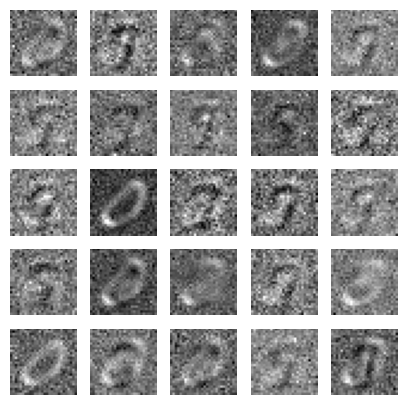

In [ ]:
# Generate 25 images
generated_images = []
for _ in range(25):
    generated_image = generate_random_image(loaded_model, noise_steps)
    generated_images.append(generated_image)

# Plot the images on a 5x5 grid
plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')
plt.show()
